# Convolutional Neural Networks (CNN) and Deep Architectures

In these practicals, we will create a first convolutional neural network (CNN). This type of networks mostly rely on alternating layers of convolution and pooling. A convolution layer is a signal processing inspired layer that performs a bunch of convolutions on the layer input and yields filtered outputs known as feature maps. A pooling layer is a sort of subsampling layer. Most of the time, after several Conv/Pool layer pairs, an MLP is plugged to obtain class membership probabilities. When the number of layers is rather high (unclear how high this is), we obtain a deep network.

We will use `TensorFlow v2.O` (or higher) as programming framework and build a CNN to solve an image classification task.

## Starting with TensorFlow

`TensorFlow` is Google's library designed to create and train deep nets. It relies on an underlying computation graph. Each node of this graph performs an operation on an input tensor. The possible number of ops is very large (ranging from addition, dot product and more complex non-linear operations). The input tensor of the network will flow through these nodes, hence the name of the library. 

Here is an example of computation graph:

<img src="graph.png" alt="drawing" width="200"/>

This graph is a tree whose final node output correponds to the following function :

$$f\left( x,y\right) = x^2 + 2y,$$

for some $x$ and $y$. 
To implement this tree in `TensorFlow`, each node will be an instance of the `Tensor` class. 
Let us start with the inputs of function $f$ and suppose, we are interested in evaluation function $f$ for the following three pairs $(x,y)$:
* $(x,y) = (1,2)$
* $(x,y) = (2,3)$
* $(x,y) = (3,4)$

Starting with $x$, we shall define a tensor containing the successive values of this input : 
```python
x = tf.constant([1,2,3])
type(x)
```
The console answers that `x` has type `<class 'tensorflow.python.framework.ops.EagerTensor'>`. Let us forget about the "eager" version and focus on the fact `x`is indeed a tensor ! 

Now we do the same with $y$:
```python
y = tf.constant([2,3,4])
```
We don't have to define a python variable for each node of the computation graph. We can now ask `TensorFlow` to build the whole graph by typing:

```python
f = x*x + 2*y
print(f)
```
The console answers: `tf.Tensor([ 5 10 17], shape=(3,), dtype=int32)`. 
Observe that `f` is a tensor that contains the three desired evaluations of function $f$. If one is only interested in observing the array of values contained in `f`, one can ask for the corresponding `numpy` array:

```python
print(f.numpy())
```

Before moving to our first exercise, let us remark that instances of `Tensor` are immutable objects ! **They can be assigned only once**. These objects are not meant to vary accross training. For instance, if one types:

```python
x[0]=10
```
The console answers : `TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment`.

In the next practical session, we will use other tensorflow objects that accept multiple assignments: `tf.Variable`.

Here is a cell containing the above instructions.

In [1]:
import tensorflow as tf
x = tf.constant([1,2,3])
print(type(x))
y = tf.constant([2,3,4])
f = x*x + 2*y
print(f)
print(f.numpy())
x[0]=10

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([ 5 10 17], shape=(3,), dtype=int32)
[ 5 10 17]


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

## Baseline CNN

We are now almost ready to start building a `TensorFlow` graph containing convolution or pooling layers instead of the basic operations involved in function $f$. 
But first things first ! We need a dataset to work with and to load in Jupyter. We will be working with the `MNIST` dataset. This dataset contains 28x28 grayscale images of handwritten figures. It has the advantage to be larger than traditional datasets utilized in practicals while it can still hold in memory and converge in a few minutes. Larger or more complicated datasets (more variability in images) would require too many computational efforts.

Execute the following cell to load `MNIST`

5


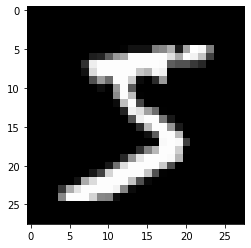

In [2]:
import numpy as np
import matplotlib.pyplot as plt

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255 - 0.5
x_train = x_train.astype('float32')
x_test = x_test/255 - 0.5
x_test = x_test.astype('float32')
#
print(y_train[0])
plt.imshow(x_train[0], cmap='gray', interpolation="nearest")
plt.show()

Let us define some constants that we be useful in the sequel

In [3]:
n = x_train.shape[0]
d_x = x_train.shape[1]
print(x_train.shape[1:])

(28, 28)


We can now begin to build the CNN. Following the explanations in the preamble, it seems like we need to turn the arrays of the dataset into `Tensor` instances. That won't be explicitely necessary because `TensorFlow` will do that on its own. So we can readily define a firt convoluational layer that we will connect to the array `x_train`. 

A second point to mention is that we will use high level functions in this practical session, i.e. functions that in reality translate in multiple nodes of the graph. These functions and classes belong to the `Keras` API. It is accessiable through `tf.Keras`. Note that the backend of this API is `TensorFlow` itself !! So using `Keras` somewhat shadows the use of the computation graph. However, we will see that building a model with `Keras` follows the same philosophy of piling up operations.

To use `Keras` functions, we need to prepare ourselves a little bit:
* by reshaping our input tensor as 4D tensor where the 4th and last dimension is 1. Later in the graph, this dimension will be larger because we will use multiple filters,
* by creating an instance from `tf.keras.Input` which is compatible with `x_train` and plays the role of "input layer" for a `Keras` model even if it does not contain actual data

### Q1
* Reshape `x_train` by adding a 4th dimension of size 1 to it. This dimension is referred to as "image channel".
* Fill the gap in the instantiation of `tf.keras.Input`. The `shape` parameter must receive a tuple containing image height, image width and image channels. This means that the dataset size is not passed to the constructor because `Keras` does not need this information to build a model.

In [4]:
x_train = np.reshape(x_train,(n,d_x,d_x,1))
inputs = tf.keras.Input(shape=x_train.shape[1:])
print(inputs.shape)


(None, 28, 28, 1)


The next element of our NN is a 2D convolutional layer. We can use an instance of `tf.keras.layers.Conv2D` class. We need to specify the number of size of filters (kernels) that we want, what filter size, how to deal with image borders (padding) and what activation we would like. 

This layer is plugged to the input layer by passing it as input, as if `conv1` was also a function. This way of connecting `Keras` layers will be the same in the sequel.

This gives:


In [5]:
# Convolutional Layer #1
conv1 = tf.keras.layers.Conv2D(
      filters=64,
      kernel_size=[5, 5],
      padding="valid",
      activation=tf.nn.relu)(inputs)

Next, we need a pooling layer to give up some entries of the filtered images provided by the convolutional layer. We will use the usual max pool function in 2x2 neighborhoods which drops 3 entries out of 4 in each such neighborhood. The remaining entry is the one achieving maximal value in the neighborhood.

In [6]:
# Pooling Layer #1
pool1 = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(conv1)

### Q2
* Why is `strides=2` the correct parameter value for our goal ? 
* What is the size of each feature map after max pooling ?
* How many feature maps are there ?


-We use strides=2 because we want to decrease the sizes of feature maps.

-In MaxPooling input, we have this size from the previous convolution layer : (24,24) (28-5+1), with MaxPooling, we divide feature maps size by 2 so we obtain (12,12).

-As in the previous layer we have chosen 64 as the number of filter, we have 64 feature maps before MaxPooling, after MaxPooling, we still have 64 feature maps.


We will now plug a 1-layer-MLP on top of this. Fully connected layers (or dense layers) do not accept 4D tensors but 2D ones. We can use `tf.reshape` to flatten feature maps / images to vectors. In the following code the scalar `dflat` = nbr of feature maps x feature map width x feature map height. 




### Q3
* Set this variable with the correct value and execute the following code line: 

In [7]:
dflat = pool1.shape[1]*pool1.shape[2]*pool1.shape[3]
pool2_flat = tf.reshape(pool1, [-1, dflat])

Now the first layer MLP is given by an instance of `tf.keras.layers.Dense` as:

In [8]:
mlp = tf.keras.layers.Dense(units=1024, activation=tf.nn.relu)(pool2_flat)

Finally, we need a softmax layer to obtain class membership probabilities. This can be done in this way:

In [9]:
logits = tf.keras.layers.Dense(units=10)(mlp)
smax = tf.keras.layers.Softmax()(logits)
model = tf.keras.Model(inputs=inputs, outputs=smax)


Next, we need to compile the `Keras` model. During this operation, we give the desired values for remaining hyperparameters. We also specify a loss, which in our case is cross-entropy. 

After compiling, `Keras` allows to have an overview of the model by invoking the `summary` function. This shows us how many parameters there are per layer. 

### Q4
* Explain these numbers layer per layer.



In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 tf.reshape (TFOpLambda)     (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 1024)              9438208   
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                             

One of greatest feature of `Keras` is that the training loop is directly implemented through the `fit` function of our model. Let us start training our model for 2 epochs

In [14]:
model.fit(x=x_train, y=tf.keras.utils.to_categorical(y_train), batch_size=20, epochs=2) 

Epoch 1/2
 255/3000 [=>............................] - ETA: 1:59 - loss: 0.0210 - categorical_accuracy: 0.9924

KeyboardInterrupt: 

To check that we did not overfit, we need to evaluate our model on the test set.

## Q5
* reshape `x_test` in a 4D tensor just like we did for `x_train`
* document yourself on the evaluate function of `tf.Keras.Model` and compute the model accuracy on the test set

In [18]:
n_test=x_test.shape[0]
x_test = np.reshape(x_test,(n_test,d_x,d_x,1))
res = model.evaluate(x=x_test,y=tf.keras.utils.to_categorical(y_test))

313/313 [==============================] - 2s 4ms/step - loss: 0.0320 - categorical_accuracy: 0.9905


### Q6
* Add a second pair of conv/pool layers. A smaller amount amount of filters and smaller filters are recommended.


In [19]:
conv1 = tf.keras.layers.Conv2D(
      filters=64,
      kernel_size=[5, 5],
      padding="valid",
      activation=tf.nn.relu)(inputs)

pool1 = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(conv1)

conv2 = tf.keras.layers.Conv2D(
      filters=32,
      kernel_size=[4, 4],
      padding="valid",
      activation=tf.nn.relu)(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(conv2)

dflat_2 = pool2.shape[1]*pool2.shape[2]*pool2.shape[3]
pool2_flat = tf.reshape(pool2, [-1, dflat_2])

mlp = tf.keras.layers.Dense(units=1024, activation=tf.nn.relu)(pool2_flat)

logits = tf.keras.layers.Dense(units=10)(mlp)
smax = tf.keras.layers.Softmax()(logits)
model = tf.keras.Model(inputs=inputs, outputs=smax)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),])
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 9, 9, 32)          32800     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 tf.reshape_2 (TFOpLambda)   (None, 512)               0   

In [20]:
model.fit(x=x_train, y=tf.keras.utils.to_categorical(y_train), batch_size=20, epochs=2) 

Epoch 1/2
3000/3000 [==============================] - 39s 13ms/step - loss: 0.1022 - categorical_accuracy: 0.9685
Epoch 2/2
3000/3000 [==============================] - 39s 13ms/step - loss: 0.0413 - categorical_accuracy: 0.9877


In [21]:
n_test=x_test.shape[0]
x_test = np.reshape(x_test,(n_test,d_x,d_x,1))
res = model.evaluate(x=x_test,y=tf.keras.utils.to_categorical(y_test))

313/313 [==============================] - 2s 4ms/step - loss: 0.0371 - categorical_accuracy: 0.9891



### Q7
* Add a second fully connected layer. A smaller number of units is recommended.


In [22]:
conv1 = tf.keras.layers.Conv2D(
      filters=64,
      kernel_size=[5, 5],
      padding="valid",
      activation=tf.nn.relu)(inputs)

pool1 = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(conv1)

conv2 = tf.keras.layers.Conv2D(
      filters=32,
      kernel_size=[4, 4],
      padding="valid",
      activation=tf.nn.relu)(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(conv2)

dflat_2 = pool2.shape[1]*pool2.shape[2]*pool2.shape[3]
pool2_flat = tf.reshape(pool2, [-1, dflat_2])

mlp1 = tf.keras.layers.Dense(units=1024, activation=tf.nn.relu)(pool2_flat)

mlp2 = tf.keras.layers.Dense(units=512, activation=tf.nn.relu)(mlp1)

logits = tf.keras.layers.Dense(units=10)(mlp2)
smax = tf.keras.layers.Softmax()(logits)
model = tf.keras.Model(inputs=inputs, outputs=smax)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 32)          32800     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 tf.reshape_3 (TFOpLambda)   (None, 512)               0   

In [23]:
model.fit(x=x_train, y=tf.keras.utils.to_categorical(y_train), batch_size=20, epochs=2) 

Epoch 1/2
3000/3000 [==============================] - 46s 15ms/step - loss: 0.1158 - categorical_accuracy: 0.9649
Epoch 2/2
3000/3000 [==============================] - 46s 15ms/step - loss: 0.0499 - categorical_accuracy: 0.9852


In [25]:
n_test=x_test.shape[0]
x_test = np.reshape(x_test,(n_test,d_x,d_x,1))
res = model.evaluate(x=x_test,y=tf.keras.utils.to_categorical(y_test))

313/313 [==============================] - 2s 5ms/step - loss: 0.0391 - categorical_accuracy: 0.9893



### Q8 (optional)
From the above NN architecture, try to tweak the other hyperparameters and comment on the sensitivity of the results wrt them. These latter include:
* the learning rate,
* the regularization strength (if regularization is activated),
* number of filters,
* filter sizes,
* activiation functions,
* strides,
* padding types,
* ...

### Q9
* Compare the obtained accuracy to that of a regularized Softmax regression from `sklearn`.